In [1]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
#MNIST Dataset
train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
print(train_set[0][0].size)
train_loader = torch.utils.data.DataLoader(train_set
    ,batch_size=32
    ,shuffle=True
)

torch.set_printoptions(linewidth=120)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

<built-in method size of Tensor object at 0x7fbfd3c08db0>


In [4]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()


In [91]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.device = torch.device('cuda')
    #conv1 | input=28*28*1 | output=24*24*6 | RF=5
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    #MP1 | input=24*24*6 | output=12*12*6 | RF=10
    #conv2 | input=12*12*6 | output=8*8*12 | RF=14
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    #conv3 | input=8*8*12 | output=4*4*32 | RF=18
    self.conv3 = nn.Conv2d(in_channels=12, out_channels=32, kernel_size=5)
    #MP2 | input=4*4*32 | output=2*2*32 | RF=36
    #FC1 | input=2*2*32 | out_features = 32
    self.fc1 = nn.Linear(in_features=32*2*2, out_features=32)
    #Output/MNIST | input=32 | out_features=10
    self.out = nn.Linear(in_features=32, out_features=10)
    #FC2/Sum | input=20 | out_features=19
    self.fc2 = nn.Linear(in_features=20, out_features=19)
  
  def forward(self, t, num, model):
    x = t.to(self.device)
    if model == 'mnist':
      # input layer
      
      # conv1 layer
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2, stride=2)
      # conv2 layer
      x = self.conv2(x)
      x = F.relu(x).to(self.device)
      
      #conv3 1d conv layer
      x = self.conv3(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2, stride=2)
      
      # reshape
      #print(x.shape)
      x = x.reshape(-1, 32*2*2)
      
      # fc1 layer
      x = self.fc1(x)
      x = F.relu(x)
      
      # fc2 layer
      #x = self.fc2(x)
      #x = F.relu(x)
      
      # output layer
      x = self.out(x)
      #print(x.size())
      #print(num.size())
      #print(torch.transpose(num, 0, 1).size())
    if model == 'sum':
      #merge prediction and random number
      x=torch.cat((x, num), 1)
      #x = F.relu(x)
      x = self.fc2(x)


    #x = F.softmax(x, dim=1)
    return x

In [6]:
def get_random_num(batch_size):
  return torch.tensor([[random.randrange(1,10) for i in range(0,batch_size)]])

In [41]:
r=get_random_num(5)
print(r[0])
num = F.one_hot(r[0], num_classes=10)
r
print(num)
print(num.reshape(-1,5))
print(num.transpose(0,1))
print(num[0])
torch.tensor(1).item()

tensor([4, 6, 4, 8, 3])
tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])
tensor([[0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]])
tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


1

In [52]:
rand_num = F.one_hot(get_random_num(32)[0], num_classes=10)
print(rand_num)
print(rand_num.argmax(dim=1))

tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],


In [64]:
rand_num_dataset = get_random_num(60000)
rand_num_dataset[0][0:3]

tensor([8, 8, 6])

In [93]:
network = Network()
device = torch.device('cuda')
network.to(device)
#generate random numbers
rand_num_dataset = get_random_num(60000)
rand_num_dataset.to(device)

torch.set_grad_enabled(True)

for epoch in range(30):
    total_loss = 0
    total_correct_mnist = 0
    total_correct_sum = 0
    lr = 1/((epoch+1)*(epoch+1))
    optimizer = optim.Adam(network.parameters(), 0.01)
    count=0
    i=0;
    alternate = True
    for batch in train_loader: # Get Batch
        rand_num = rand_num_dataset[0][i*32:(i*32)+32]
        i+=1
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        rand_num_oh = F.one_hot(rand_num, num_classes=10).to(device) #.reshape(-1,len(images))
        #print(rand_num_oh)

        preds_mnist = network(images, rand_num_oh, 'mnist') # Pass Batch
        preds_sum = network(preds_mnist.to(device), rand_num_oh, 'sum') # Pass Batch
        '''
        if count==0:
          print('preds_mnist: ', preds_mnist[0])
          print('label_mnist: ', labels[0])
          print('label rand num: ', rand_num_oh[0])
          print('preds_sum: ', preds_sum[0])
          count=1
        '''

        #alternate loss calculations for mnist and the sum
        if alternate:
          alternate=False
          loss_mnist = F.cross_entropy(preds_mnist, labels) # Calculate Loss
          optimizer.zero_grad()
          loss_mnist.backward() # Calculate Gradients
          optimizer.step() # Update Weights
          total_loss += loss_mnist.item()

        else:
          alternate=True
          loss_sum = F.cross_entropy(preds_sum, torch.add(labels, rand_num_oh.argmax(dim=1))) # Calculate Loss
          optimizer.zero_grad()
          loss_sum.backward() # Calculate Gradients
          optimizer.step() # Update Weights
          total_loss += loss_sum.item()


        total_correct_mnist += get_num_correct(preds_mnist, labels)
        total_correct_sum += get_num_correct(preds_sum, torch.add(labels, rand_num_oh.argmax(dim=1)))
        #print('loss after batch: '+str(total_loss))
        #print('correct after batch: '+str(total_correct))

    print(
        "epoch:", epoch, 
        "total_correct_mnist:", total_correct_mnist,
        "total_correct_sum:", total_correct_sum,
        "loss:", total_loss
    )


epoch: 0 total_correct_mnist: 53706 total_correct_sum: 17776 loss: 2064.8953717714176
epoch: 1 total_correct_mnist: 57398 total_correct_sum: 24674 loss: 1517.9885627613403
epoch: 2 total_correct_mnist: 57648 total_correct_sum: 28366 loss: 1374.942780266516
epoch: 3 total_correct_mnist: 57848 total_correct_sum: 30649 loss: 1290.4936307533644
epoch: 4 total_correct_mnist: 57951 total_correct_sum: 32807 loss: 1225.9846690070117
epoch: 5 total_correct_mnist: 58001 total_correct_sum: 34011 loss: 1195.7824630569667
epoch: 6 total_correct_mnist: 58130 total_correct_sum: 34954 loss: 1153.8741208070423
epoch: 7 total_correct_mnist: 58105 total_correct_sum: 35625 loss: 1134.3785340045579
epoch: 8 total_correct_mnist: 58171 total_correct_sum: 36373 loss: 1111.2108169090934
epoch: 9 total_correct_mnist: 58173 total_correct_sum: 36729 loss: 1096.41110892687
epoch: 10 total_correct_mnist: 58035 total_correct_sum: 37198 loss: 1095.3350114913192
epoch: 11 total_correct_mnist: 58124 total_correct_sum: 

In [94]:
test_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_loader = torch.utils.data.DataLoader(test_set
    ,batch_size=32
    ,shuffle=True
)

#print(next(iter(test_loader)))
#image, label = next(iter(test_loader))
#plt.imshow(image.squeeze(), cmap='gray')
#print('label:', label)

In [ ]:
total_mnist_correct = 0
total_sum_correct = 0

for batch in test_loader:
  images, labels = batch
  rand_num = get_random_num(len(images))

  preds_mnist = network(images, rand_num, 'mnist') # Pass Batch
  #print(preds_mnist.size())
  preds_sum = network(preds_mnist, rand_num, 'sum') # Pass Batch
  total_mnist_correct += get_num_correct(preds_mnist, labels)
  total_sum_correct += get_num_correct(preds_sum, torch.add(labels, rand_num[0]))

print('MNIST Accuracy' + str(total_mnist_correct/test_set.size()))
print('Sum Accuracy' + str(total_sum_correct/test_set.size()))



label: tensor(6)
mnist_prediction:  tensor(6, device='cuda:0')
random number: tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]], device='cuda:0')
6 + 3 = 9


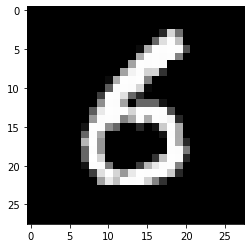

In [100]:
images, labels = next(iter(test_loader))
plt.imshow(images[0].squeeze(), cmap='gray')
print('label:', labels[0])
mnist_prediction = network(images[0],None, 'mnist')
print('mnist_prediction: ', torch.argmax(mnist_prediction))
random_num = F.one_hot(get_random_num(1)[0], num_classes=10).to(torch.device('cuda'))
print('random number:', random_num)
result = torch.argmax(network(mnist_prediction, random_num, 'sum'))
print(labels[0].tolist(), '+', torch.argmax(random_num[0]).tolist(), '=', result.tolist())